# Color

In [1]:
import matplotlib.pyplot as plt
import skimage

## Examples using `skimage.color.gray2rgb`

### Tinting gray-scale images
[link to example](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_tinting_grayscale_images.html#sphx-glr-auto-examples-color-exposure-plot-tinting-grayscale-images-py)

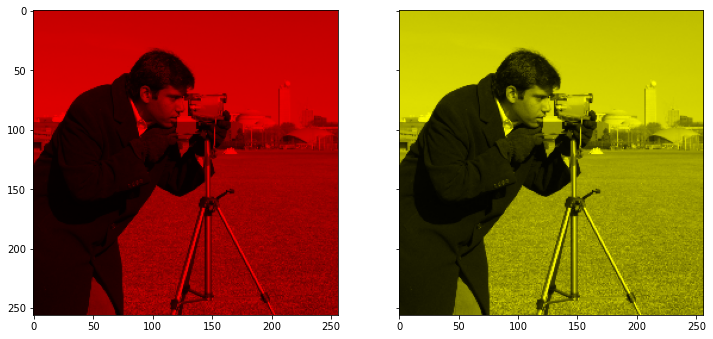

In [2]:
grayscale_image = skimage.img_as_float(skimage.data.camera()[::2, ::2])
image = skimage.color.gray2rgb(grayscale_image)

red_multiplier = [1, 0, 0]
yellow_multiplier = [1, 1, 0]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6), sharex=True, sharey=True)

ax1.imshow(red_multiplier * image)
ax2.imshow(yellow_multiplier * image)

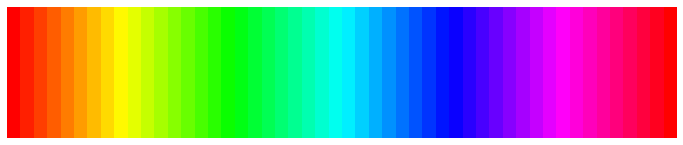

In [3]:
import numpy as np

hue_gradient = np.linspace(0,1)
hsv = np.ones(shape=(1, len(hue_gradient), 3), dtype=float)
hsv[:, :, 0] = hue_gradient

all_hues = skimage.color.hsv2rgb(hsv)

fig, ax = plt.subplots(figsize=(12, 6))
# Set image extent so hues go from 0 to 1 and the image is a nice aspect ratio
ax.imshow(all_hues, extent=(
    0 - 0.5 / len(hue_gradient),
    1 + 0.5 / len(hue_gradient), 0, 0.2
))
ax.set_axis_off()

Let's create a litte utility function to take an RGB image and:
1. Transform the RGB image to HSV
2. Set the hue and saturation
3. Transform the HSV image back to RGB

In [6]:
def colorize(image, hue, saturation=1):
    """Add color of the given hue to an RGB image.
    By default, set the saturation to 1 so that the colors pop!
    """

    hsv = skimage.color.rgb2hsv(image)
    hsv[:, :, 1] = saturation
    hsv[:, :, 0] = hue
    return skimage.color.hsv2rgb(hsv)

Using the function above, we plot six images with a linear gradient in the hue and a non-zero saturation:

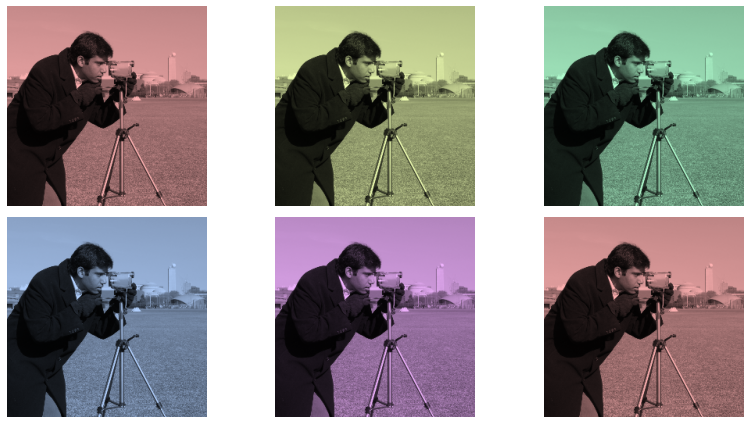

In [8]:
hue_rotations = np.linspace(0, 1, 6)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6), sharex=True, sharey=True)

for ax, hue in zip(axes.flat, hue_rotations):
    # Turn down the saturation to give it that vintage look.
    tinted_image = colorize(image, hue, saturation=0.3)
    ax.imshow(tinted_image, vmin=0, vmax=1)
    ax.set_axis_off()
fig.tight_layout()

You can combine this tinting effect with numpy slicing and fancy-indexing to selectively tint your images.

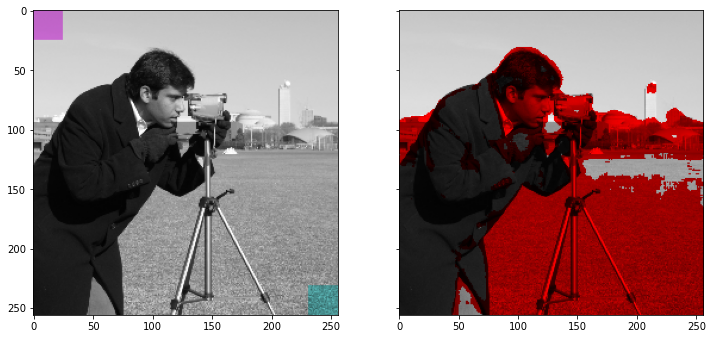

In [14]:
# Square regions defined as slices over the first two dimensions
top_left = (slice(25), ) * 2
bottom_right = (slice(-25, None), ) * 2

sliced_image = image.copy()
sliced_image[top_left] = colorize(image[top_left], 0.82, saturation=0.5)
sliced_image[bottom_right] = colorize(image[bottom_right], 0.5, saturation=0.5)

# Create a mask selecting regions with interesting texture.
noisy = skimage.filters.rank.entropy(skimage.util.img_as_ubyte(grayscale_image), np.ones((9,9)))
textured_regions = noisy > 4.25

# Note that using `colorize` here is a bit more difficult, since `rgb2hsv`
# expects an RGB image (height x width x channel), but fancy-indexing returns
# a set of RGB images (# pixels x channel).
masked_image = image.copy()
masked_image[textured_regions, :] *= red_multiplier

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 6), sharex=True, sharey=True)
ax1.imshow(sliced_image)
ax2.imshow(masked_image)

plt.show()

Let's go back and see how `noisy` and `textured_regions` actually look like:

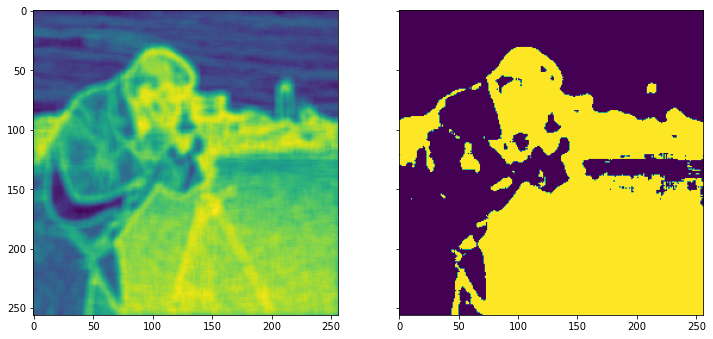

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,6), sharex=True, sharey=True)
ax1.imshow(noisy)
ax2.imshow(textured_regions)

### Circular and Elyptical Hough Transforms
[link to example](https://scikit-image.org/docs/stable/auto_examples/edges/plot_circular_elliptical_hough_transform.html#sphx-glr-auto-examples-edges-plot-circular-elliptical-hough-transform-py)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

#### Circle Detection

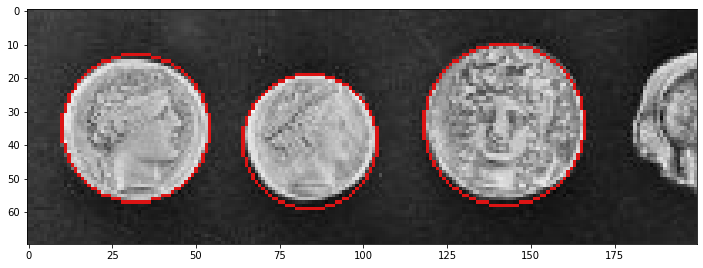

In [21]:
# Load picture and detect edges
image = skimage.util.img_as_ubyte(skimage.data.coins()[160:230, 70:270])
edges = skimage.feature.canny(image, sigma=3, low_threshold=10, high_threshold=50)

# Detect two radii
hough_radii = np.arange(20, 35, 2)
hough_res = skimage.transform.hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = skimage.transform.hough_circle_peaks(hough_res, hough_radii, total_num_peaks=3)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 6))
image = skimage.color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = skimage.draw.circle_perimeter(center_y, center_x, radius, shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

#### Ellipse Detection

result: 7


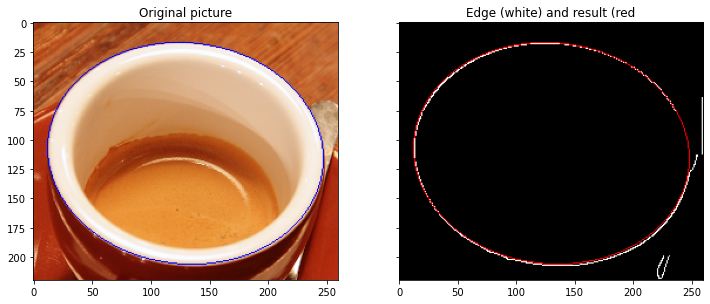

In [30]:
# Load picture, convert to grayscale and detect edges
image_rgb = skimage.data.coffee()[0:220, 160:420]
image_gray = skimage.color.rgb2gray(image_rgb)
edges = skimage.feature.canny(image_gray, sigma=2.0, low_threshold=0.55, high_threshold=0.8)

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = skimage.transform.hough_ellipse(edges, accuracy=20, threshold=250, min_size=100, max_size=120)
result.sort(order='accumulator')

print(f"result: {len(result)}")
# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = skimage.draw.ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = skimage.color.gray2rgb(skimage.util.img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,6), sharex=True, sharey=True)

ax1.set_title("Original picture")
ax1.imshow(image_rgb)

ax2.set_title("Edge (white) and result (red")
ax2.imshow(edges)

plt.show()

#### Region Boundary based RAGs
[link to example](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_rag_boundary.html#sphx-glr-auto-examples-segmentation-plot-rag-boundary-py)

In [31]:
import skimage
from matplotlib import pyplot as plt

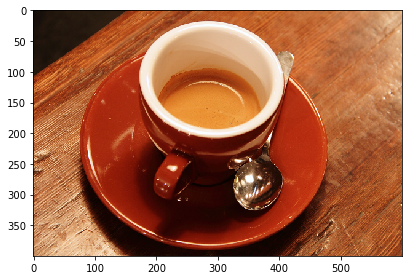

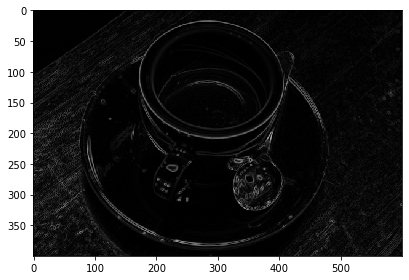

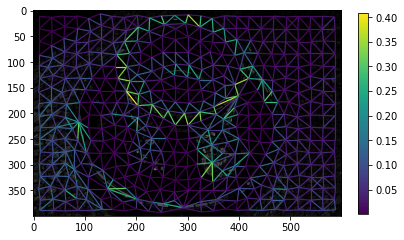

In [40]:
img = skimage.data.coffee()
gray_img = skimage.color.rgb2gray(img)

labels = skimage.segmentation.slic(img, compactness=30, n_segments=400, start_label=1)
edges = skimage.filters.sobel(gray_img)
edges_rgb = skimage.color.gray2rgb(edges)

g = skimage.future.graph.rag_boundary(labels, edges)

# Show image and edges beforehand
skimage.io.imshow(img)
skimage.io.show()
skimage.io.imshow(edges)
skimage.io.show()

# Show actual RAG
lc = skimage.future.graph.show_rag(
    labels, g, edges_rgb, img_cmap=None, edge_cmap='viridis', edge_width=1.2
)
plt.colorbar(lc, fraction=0.03)
skimage.io.show()